# Laboratorio 4: Aprendizaje Supervisado

> **Análisis de las Posiciones del Aborto en Twitter**
> *Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus aplicaciones.*
> *Integrantes: 
    - Carlos Piaggio
    - Juan Pablo Analian
    
- [Notebook 1](entrega_04_v7.ipynb)
- [Notebook 3](entrega_04_v9.ipynb)
    
## Parte 2/3 (probando modelos del TP3)    

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from ml.visualization import plot_confusion_matrix, plot_learning_curve, classifier_boundary

 
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer

import sklearn.linear_model
from sklearn.linear_model import SGDClassifier,Perceptron
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



## 1. Cargamos dataset que hemos limpiado en la notebook anterior


In [2]:
df_full = pd.read_csv('./out/df_text_junio.csv')

In [3]:
df_full.codigo_posicion.value_counts()

1    780325
0    260839
Name: codigo_posicion, dtype: int64

## 2. Quitamos los textos duplicados (originados por los RT)

In [4]:
df = df_full.drop_duplicates(subset='text', keep="first")

In [5]:
 df.codigo_posicion.value_counts()

1    145147
0     60771
Name: codigo_posicion, dtype: int64

In [6]:
 df.head(10)

,codigo_posicion,text
0,1,contamos ventaja decision conviccion fuerza lucha
1,1,excelentes reflexiones medica ginecologa catol...
2,1,fondo jode libertad
3,1,holla gustaria q ayuden junta d firmas seguro ...
4,1,vos decis pido escuches intentes abrir mente e...
5,1,debate argumentos gano goleada legalizacion bi...
6,1,dueñas nuestrxs cuerpas
7,1,diputadxs significa ustedes mujer muerta credi
8,1,coincidamos tema cambia respeto admiracion
9,1,tan mitad tener postura definida tema entiendo...


#### Metodos auxiliares

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report 

LABELS = ['a favor','en contra']

def mostrar_resultados(y_test, y_pred):    
    print ("Accuracy score:  %.2f" % accuracy_score(y_test, y_pred))
    print ("=============================")
    print (classification_report(y_test, y_pred, labels=[1,0], target_names=LABELS))

In [23]:
def mostrar_mc(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])  #, labels=[1,0]
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix,  annot=True, fmt="d"); #xticklabels=[1,0], yticklabels=[1,0],
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    

## 3 Bag of Words (CountVectorizer)
Iniciaremos la vectorizacion de los tokens presentes en este data set reducido (ya habiendo quitado duplicados)

In [8]:
vectorizer = CountVectorizer(analyzer = "word",  tokenizer = None, preprocessor = None, stop_words = None, max_features = 6250) 
vectorizer.fit(df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=6250, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [9]:
vector = vectorizer.transform(df.text)

In [10]:
print(vector.shape)
print(type(vector))
print(vector.toarray()[0:10])

(205918, 6250)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
b = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names(), index= df.index)
df = df.join(b)

In [12]:
df.head(3)

,codigo_posicion,text,00,000,06,10,100,1000,100000,11,...,youtube,yovoy,yrigoyen,yrurtia,yuta,zapatos,zona,zurdo,zurdos,zylberberg
0,1,contamos ventaja decision conviccion fuerza lucha,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,excelentes reflexiones medica ginecologa catol...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,fondo jode libertad,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df1 = df.drop(columns=['text'])

## 3. Train - Test Split

In [16]:
y = df1['codigo_posicion'].values
X_train, X_test, y_train, y_test = train_test_split(vector, y, test_size=0.2, random_state=42)

print("X_train",X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train (164734, 6250)
X_test (41184, 6250)
y_train (164734,)
y_test (41184,)


## 4. Clasificador SDG


In [17]:
model_sdg =SGDClassifier (loss='log', penalty='l2', alpha=0.01, 
                          learning_rate='optimal', eta0 = 0.1, tol=1e-3,  
                          max_iter= 1000, random_state=42, n_jobs = 5)

model_sdg.fit(X_train, y_train)
y_pred = model_sdg.predict(X_test)

mostrar_resultados(y_test, y_pred)

Accuracy score:  0.73
              precision    recall  f1-score   support

     a favor       0.73      0.99      0.84     28979
   en contra       0.84      0.11      0.20     12205

    accuracy                           0.73     41184
   macro avg       0.78      0.55      0.52     41184
weighted avg       0.76      0.73      0.65     41184



> En el TP3, había obtenido un accuray del *82%* sobre el set de validacion (test) y aca hemos obtenido *75%*.

## 5. KNN (Nearest Neighbors)

Si bien estamos ante un problema de clasificacion binaria, queremos realizar una prueba con el algoritmo KNN el cual está mas orientado a clasificacion multiclase. 

In [18]:
model_k = KNeighborsClassifier(n_neighbors=3, n_jobs = 5)
model_k.fit(X_train, y_train)
y_pred = model_k.predict(X_test)

mostrar_resultados(y_test, y_pred)

Accuracy score:  0.76
              precision    recall  f1-score   support

     a favor       0.82      0.85      0.83     28979
   en contra       0.60      0.56      0.58     12205

    accuracy                           0.76     41184
   macro avg       0.71      0.70      0.71     41184
weighted avg       0.76      0.76      0.76     41184



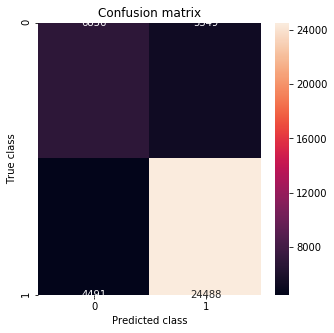

In [24]:
mostrar_mc(y_test, y_pred)

## 6. Regresion Logistica

/users/jpanalian/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Accuracy score:  0.82
              precision    recall  f1-score   support

     a favor       0.84      0.92      0.88     28979
   en contra       0.76      0.58      0.66     12205

    accuracy                           0.82     41184
   macro avg       0.80      0.75      0.77     41184
weighted avg       0.82      0.82      0.81     41184



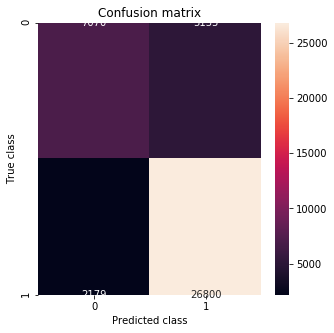

In [25]:
model_l = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr' , n_jobs = 5)
model_l.fit(X_train, y_train)
y_pred = model_l.predict(X_test)

mostrar_resultados(y_test, y_pred)
mostrar_mc(y_test, y_pred)

## 7. Arboles de desicion

Accuracy score:  0.72
              precision    recall  f1-score   support

     a favor       0.72      0.99      0.83     28979
   en contra       0.81      0.07      0.12     12205

    accuracy                           0.72     41184
   macro avg       0.76      0.53      0.48     41184
weighted avg       0.74      0.72      0.62     41184



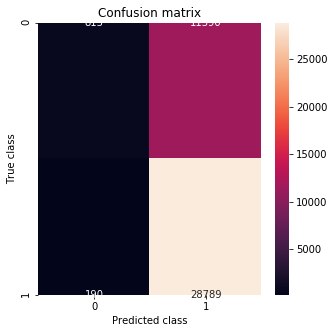

In [26]:
model_t = tree.DecisionTreeClassifier(max_depth=2, random_state=42 )
model_t.fit(X_train, y_train)
y_pred = model_t.predict(X_test)

mostrar_resultados(y_test,y_pred )
mostrar_mc(y_test, y_pred)

## 8 RandomForest

Accuracy score:  0.72
              precision    recall  f1-score   support

     a favor       0.72      1.00      0.83     28979
   en contra       0.93      0.07      0.12     12205

    accuracy                           0.72     41184
   macro avg       0.82      0.53      0.48     41184
weighted avg       0.78      0.72      0.62     41184



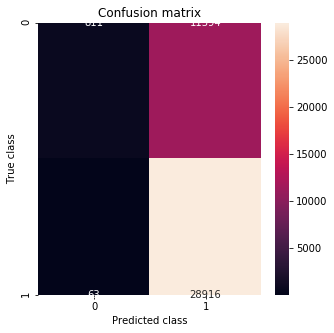

In [27]:
model_rf = RandomForestClassifier(n_estimators= 100, max_depth = 20, min_samples_split=10, random_state=42, n_jobs=5)    
model_rf.fit(X_train, y_train)    
y_pred = model_rf.predict(X_test)    

mostrar_resultados(y_test, y_pred)    
mostrar_mc(y_test, y_pred)
#inició:15:58  terminó: 16:03